# Project: Investigate a Dataset - Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

In this dataset, we are given seven tables with information about soccer matches, leagues, teams and players. We can find relationships between some of these tables, which may help us to traverse and correlate the distributed information. Below, each table is described, explaining its columns and relationships with other tables within the dataset:

* **Country**: this table hosts information about countries where matches took event. We'll skip the details of this table, as we won't make use of it for our analysis.
* **League**: this table offers basic information about a league where different teams disputed a set of matches within a country (so it is directly related to `Country` and `Match` tables). These are the columns of the table:
  * `id` (`int`, primary key): unique identifier of each league.
  * `country_id` (`int`, `Country` foreign key): reference to a country from `Country` table.
  * `name` (`String`): league name.
* **Match**: this table is quite complex, as it not only offers game data (such as goals per team, season, date...) but also betting data. For the scope of this exercise, we'll only put focus on the game data (so we'll need to clean the columns not needed later on with `pandas`). The table columns useful for this exercise are:
  * `id` (`int`, primary key): unique identifier of the match.
  * `country_id` (`int`, `Country` foreign key): reference to a country from `Country` table.
  * `league_id` (`int`, `League` foreign key): reference to a league from `League` table.
  * `date` (`String/Date`): specifies in which day was the match played.
  * `home_team_api_id` (`int`, `Team` foreign key): reference to a team from `Team` table. This team was the _host_ of the game (the match took place on its stadium).
  * `away_team_api_id` (`int`, `Team` foreign key): reference to a team from `Team` table. This team was the _guest_ of the game (the one playing on a foreign stadium).
  * `home_team_goal` (`int`): number of goals scored by the team identified through `home_team_api_id`
  * `away_team_goal` (`int`): number of goals scored by the team identified through `away_team_api_id`
  The table offers other fields such as `stage`, `goal`, `shoton`, `possession`... which are discarded due to lack of documentation and data inconsistency (some of these values are raw HTML unsuitable for analysis). Additionally, we'll skip `player`-specific columns, as we won't put focus on players for our analysis, but on the overall team attributes (see posed questions below). It may be interesting to add a couple of columns to this table indicating the id of the winner and loser teams.
* **Player**: in this table we find specific attributes describing the athletes who played the game. Since we'll be focusing on team aspects for our analysis (see posed questions below), we'll skip the details of this table.
* **Player_Attributes**: this table describes different athlete attributes at different points of time, extracted from Electronic Arts (EA) Sports' FIFA video game. The contents of this table can be useful to correlate team victories/loses according to the players in the match. The table has up to 42 columns with different athlete statistics. Again, we'll skip the details of this table, as we're not interested on it for our analysis (see posed questions below).
* **Team**: this table hosts information about the teams that played matches. The main columns are:
  * `id` (`int`, primary key): just like with table `Player`, this won't be used.
  * `team_api_id` (`int`, unique key): this is the identifier that will be used to traverse relationships between tables. It uniquely identifies a team.
  * `team_short_name` (`string`): short identifier for the team. Usually, this is the text we can find in the score board to identify each team.
  * `team_long_name` (`String`): full team name.
* **Team_Attributes**: in this table, we can find again data from EA Sports describing each team. The table has up to 25 columns with different team statistics. After posing the questions for the analysis, we'll decide which ones are interesting for us. For now, it's important no know about the following columns:
  * `id` (`int`, primary key): unique identifier of the attributes.
  * `team_api_id` (`int`, `Team` foreign key): reference to a team from `Team` table.
  * `date` (`String/Date`): when do these attributes belong to the team.


### Question(s) for Analysis
In this exercise, we'll be interested in finding trends among the teams who won most matches and how they differ to those who lost the most. Since we have specific attributes about the teams themselves, and about the players that build up a team, we can pose questions to try find out how these affect to the match result:

_Q1: What team attributes lead to the most victories?_  
_Q2: If we split the winners by league, do their team attributes vary?_  

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [162]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling

### General Properties

As we saw earlier on the Dataset Description section, we will be making use of tables `League`, `Match`, `Team_Attributes` and `Team`. We will take a quick look at their structure, datatypes and values to get a first picture of the data we're dealing with.

#### League

In [163]:
df_league = pd.read_csv('League.csv', index_col='id')
df_league.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 24558
Data columns (total 2 columns):
country_id    11 non-null int64
name          11 non-null object
dtypes: int64(1), object(1)
memory usage: 264.0+ bytes


We can see this dataframe has 11 rows and 3 columns (as described above). In order to make sure that the columns' values fullfill the datatypes we'll print some of them:

In [164]:
df_league.head()

,country_id,name
id,,
1,1,Belgium Jupiler League
1729,1729,England Premier League
4769,4769,France Ligue 1
7809,7809,Germany 1. Bundesliga
10257,10257,Italy Serie A


We can see that the values match their types. Finally, we'll look for duplicated values (we already know there are no `null` values as reported through `.info()`):

In [165]:
df_league.duplicated().sum()

0

There are no duplicates.

#### Match

In [166]:
df_match = pd.read_csv('Match.csv', index_col='id')
df_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 1 to 25979
Columns: 114 entries, country_id to BSA
dtypes: float64(96), int64(8), object(10)
memory usage: 22.8+ MB


This table is quite large, it contains 115 columns, which is greater than `pandas.options.display.max_info_columns` (100), therefore `pandas` won't print the columns info. In order to get the data types and obvserve null values, we could either increase this option value, or analyze the subset we're interested on. Priorizing performance, we'll just analyze the subset we're interested on (we'll cut the dataframe on section Data Cleaning):

In [167]:
match_cols = ["season", "country_id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]
df_match[match_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 1 to 25979
Data columns (total 8 columns):
season              25979 non-null object
country_id          25979 non-null int64
league_id           25979 non-null int64
date                25979 non-null object
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(6), object(2)
memory usage: 1.8+ MB


Now we can properly see that the datatypes match the expected specification. We can also observe that the dataframe contains 25979 rows and that there are no `null` values. There's only left to take a quick look to some samples, and to check for duplicates:

In [168]:
df_match.head()

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
id,,,,,,,,,,,,,,,,,,,,,
1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [169]:
df_match[match_cols].duplicated().sum()

0

There are no duplicated rows, and the values match their column data types. Since we're highly interested on this table, we are going to check as well the time period in which we have data (this is, the earliest and latest dates):

In [170]:
print("Values range from %s to %s" % (df_match.sort_values('date').iloc[0]['date'], df_match.sort_values('date').iloc[-1]['date']))

Values range from 2008-07-18 00:00:00 to 2016-05-25 00:00:00


It's also worth inspecting what time span does a season cover. For that, we can run the following code:

In [171]:
for season in df_match['season'].value_counts().index.sort_values():
  season_matches = df_match.loc[df_match['season'] == season].sort_values('date')
  print("Season %s matches from %s to %s" % (season, season_matches.iloc[0]['date'], season_matches.iloc[-1]['date']))

Season 2008/2009 matches from 2008-07-18 00:00:00 to 2009-05-31 00:00:00
Season 2009/2010 matches from 2009-07-11 00:00:00 to 2010-05-16 00:00:00
Season 2010/2011 matches from 2010-07-17 00:00:00 to 2011-05-29 00:00:00
Season 2011/2012 matches from 2011-07-16 00:00:00 to 2012-05-23 00:00:00
Season 2012/2013 matches from 2012-07-13 00:00:00 to 2013-06-02 00:00:00
Season 2013/2014 matches from 2013-07-13 00:00:00 to 2014-05-18 00:00:00
Season 2014/2015 matches from 2014-07-18 00:00:00 to 2015-05-31 00:00:00
Season 2015/2016 matches from 2015-07-17 00:00:00 to 2016-05-25 00:00:00


Which lets us know that a season covers from the 7th month of the 1st year to the 6th month of the next one.

#### Team

In [172]:
df_team = pd.read_csv('Team.csv', index_col='id')
df_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 1 to 51606
Data columns (total 4 columns):
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 11.7+ KB


This dataframe is made of 299 rows, and the data types match the expected except for `team_fifa_api_id`. There are also some null values in `team_fifa_api_id` field, however since we're not interested in this column, we won't dig more about these. There's only left to check for duplicates and see some values:

In [173]:
df_team.head()

,team_api_id,team_fifa_api_id,team_long_name,team_short_name
id,,,,
1,9987,673.0,KRC Genk,GEN
2,9993,675.0,Beerschot AC,BAC
3,10000,15005.0,SV Zulte-Waregem,ZUL
4,9994,2007.0,Sporting Lokeren,LOK
5,9984,1750.0,KSV Cercle Brugge,CEB


In [174]:
df_team.duplicated().sum()

0

There are no duplicated rows, and the values match the data type (except for `team_fifa_api_id`, which we won't covert since we won't be using it).

#### Team Attributes

In [175]:
df_team_attrs = pd.read_csv('Team_Attributes.csv', index_col='id')
df_team_attrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 1 to 1458
Data columns (total 24 columns):
team_fifa_api_id                  1458 non-null int64
team_api_id                       1458 non-null int64
date                              1458 non-null object
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              489 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceCreationCrossing            1458 non-null int64
chanceCreationCrossingClass       1458 non-null object
chanceCreationShooting            1458 non-null int64
chanceCreationShootingClass       1458 non-null object
chanceCreationPositi

We can see there's `buildUpPlayDribbling` with missing values, but the command didn't show all of the table columns, so we need to run a different approach.

In [176]:
df_team_attrs.isnull().sum()

team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

It looks like this is the only column with `null` values. Luckily for us, we have an alternative `buildUpPlayDribblingClass`, which will allow us to infer a numeric value for `buildUpPlayDribbling` out of a human friendly description.  
`buildUpPlayDribblingClass` values are `Little`, `Normal`, and `Lots`, as we can see by the following command:

In [177]:
df_team_attrs['buildUpPlayDribblingClass'].value_counts()

Little    1004
Normal     433
Lots        21
Name: buildUpPlayDribblingClass, dtype: int64

If we get the `min`, `mean` and `max` numbers for those, **we can infer the missing values** by assigning
* `Little` = `min`
* `Normal` = `round(mean)` (as the type for this column should be `int64`)
* `Lots` = `max`

In [178]:
df_team_attrs['buildUpPlayDribbling'].describe()

count    489.000000
mean      48.607362
std        9.678290
min       24.000000
25%       42.000000
50%       49.000000
75%       55.000000
max       77.000000
Name: buildUpPlayDribbling, dtype: float64

In [179]:
df_team_attrs.duplicated().sum()

1

We can see that there is one duplicated row. We'll have to clean it later.  

During the analyisis, we will want to match team attributes with game results, so we need to check the time window in this table as well: 

In [180]:
print("Values range from %s to %s" % (df_team_attrs.sort_values('date').iloc[0]['date'], df_team_attrs.sort_values('date').iloc[-1]['date']))

Values range from 2010-02-22 00:00:00 to 2015-09-10 00:00:00


We can observe that `df_match` has a lot of info before 2010 that we won't be able to correlate. Thus, we may need to erase data in `df_match` between 2008-07-18 and 2010-02-22. Same for the other interval between 2015-09-10 and 2016-05-25. For now, we're going to populate a new `season` column on this dataframe so we can later join it with `df_match`. The condition to assign a given season to a specific row is based on the results seen for the Match table earlier.

In [181]:
def season_for_row(date):
  if (date.month < 7):
    return "{}/{}".format(date.year - 1, date.year)
  return "{}/{}".format(date.year, date.year + 1)

for i in df_team_attrs.index:
  df_team_attrs.at[i, 'season'] = season_for_row(pd.to_datetime(df_team_attrs.loc[i]['date']))

df_team_attrs.head(1)

,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,season
id,,,,,,,,,,,,,,,,,,,,,
1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,...,Normal,Organised,50,Medium,55,Press,45,Normal,Cover,2009/2010


A final point of concern here is whether there can be multiplie entries for a given team on the same season. If that's the case, we should either: pick the closer one when correlating attributes to matches, or calculate the average and use that result on the correlation:

In [182]:
for season in df_team_attrs['season'].value_counts().index.sort_values():
  season_attrs = df_team_attrs[['team_api_id', 'season']][(df_team_attrs['season'] == season)]
  print("Season %s has %s total rows. Grouping by team, there are %s rows." % (season, len(season_attrs.index), len(season_attrs.groupby('team_api_id')['season'].value_counts().index)))

Season 2009/2010 has 241 total rows. Grouping by team, there are 241 rows.
Season 2010/2011 has 244 total rows. Grouping by team, there are 244 rows.
Season 2011/2012 has 242 total rows. Grouping by team, there are 242 rows.
Season 2013/2014 has 242 total rows. Grouping by team, there are 242 rows.
Season 2014/2015 has 244 total rows. Grouping by team, there are 244 rows.
Season 2015/2016 has 245 total rows. Grouping by team, there are 244 rows.


It looks like we have a team with more than one row on season `2015/2016`, but that's expected, as we saw earlier a single duplicate.

### Data Cleaning

Before beginning the EDA, for each dataframe we'll want to make sure that:

* It only contains the columns we need for the analysis
* The datatypes are well defined
* Null values are properly addressed, either by filling with placeholder data or by dropping columns
* There are no duplicates

Thus, according to the previous section, the action items here are:
* To keep only columns `["season", "country_id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]` from `df_match`
* To remove rows from `df_match` between 2008-07-18 and 2010-02-22 and between 2015-09-10 and 2016-05-25
* To remove unused `team_fifa_api_id` from `df_team`
* To remove duplicates from `df_team_attrs`
* To assign inferred values to the `nulls` of `buildUpPlayDribbling` in `df_team_attrs`
* To set the correct data type of column `buildUpPlayDribbling` from `float64` to `int64` in `df_team_attrs`
* To remove unused `team_fifal_api_id` and `*Class` columns from `df_team_attrs`

In [183]:
df_match = df_match[["season", "country_id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]]

df_match.drop(df_match[df_match['date'] < "2010-02-22"].index, inplace=True)
df_match.drop(df_match[df_match['date'] > "2015-09-10"].index, inplace=True)

df_team.drop(columns=['team_fifa_api_id'], inplace=True)

df_team_attrs.drop_duplicates(inplace=True)
df_team_attrs.loc[df_team_attrs["buildUpPlayDribblingClass"] == "Little", "buildUpPlayDribbling"] = 24
df_team_attrs.loc[df_team_attrs["buildUpPlayDribblingClass"] == "Normal", "buildUpPlayDribbling"] = 49
df_team_attrs.loc[df_team_attrs["buildUpPlayDribblingClass"] == "Lots", "buildUpPlayDribbling"] = 77

df_team_attrs["buildUpPlayDribbling"] = df_team_attrs["buildUpPlayDribbling"].astype(int)

df_team_attrs.drop(columns=['team_fifa_api_id'], inplace=True)

for col in df_team_attrs.columns:
    if col.endswith('Class'):
        df_team_attrs.drop(columns=[col], inplace=True)

After this cleanup, we can ensure that `df_match` has the expected shape:

In [184]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17568 entries, 414 to 25969
Data columns (total 8 columns):
season              17568 non-null object
country_id          17568 non-null int64
league_id           17568 non-null int64
date                17568 non-null object
home_team_api_id    17568 non-null int64
away_team_api_id    17568 non-null int64
home_team_goal      17568 non-null int64
away_team_goal      17568 non-null int64
dtypes: int64(6), object(2)
memory usage: 1.2+ MB


As well as `df_team`:

In [185]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 1 to 51606
Data columns (total 3 columns):
team_api_id        299 non-null int64
team_long_name     299 non-null object
team_short_name    299 non-null object
dtypes: int64(1), object(2)
memory usage: 9.3+ KB


And the same for `df_team_attrs`:

In [186]:
df_team_attrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 1 to 1458
Data columns (total 12 columns):
team_api_id               1457 non-null int64
date                      1457 non-null object
buildUpPlaySpeed          1457 non-null int64
buildUpPlayDribbling      1457 non-null int64
buildUpPlayPassing        1457 non-null int64
chanceCreationPassing     1457 non-null int64
chanceCreationCrossing    1457 non-null int64
chanceCreationShooting    1457 non-null int64
defencePressure           1457 non-null int64
defenceAggression         1457 non-null int64
defenceTeamWidth          1457 non-null int64
season                    1457 non-null object
dtypes: int64(10), object(2)
memory usage: 148.0+ KB


In [187]:
df_team_attrs.duplicated().sum()

0

<a id='eda'></a>
## Exploratory Data Analysis

### What team attributes lead to the most victories?

In order to try answering this question, we firstly want to visualize which teams won the most matches with the data we have. The `df_match` holds the number of goals scored by each team per match, however for our scenario, a new column specifying the winner team would be more suitable:

In [188]:
# In this subset we separate rows where the home team won, and set a new column _winner_ to the home team id
df_home_winner = df_match.loc[df_match['home_team_goal'] > df_match['away_team_goal']].assign(winner=lambda x: x['home_team_api_id'])
df_away_loser = df_match.loc[df_match['home_team_goal'] > df_match['away_team_goal']].assign(loser=lambda x: x['away_team_api_id'])
df_home_winner['loser'] = df_away_loser['loser']

# This subset will store the info with the visitor team wins
df_away_winner = df_match.loc[df_match['home_team_goal'] < df_match['away_team_goal']].assign(winner=lambda x: x['away_team_api_id'])
df_home_loser = df_match.loc[df_match['home_team_goal'] < df_match['away_team_goal']].assign(loser=lambda x: x['away_team_api_id'])
df_away_winner['loser'] = df_home_loser['loser']

# We join them again (would be like an outer merge)
df_match = pd.concat([df_home_winner, df_away_winner])
df_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13095 entries, 414 to 25967
Data columns (total 10 columns):
season              13095 non-null object
country_id          13095 non-null int64
league_id           13095 non-null int64
date                13095 non-null object
home_team_api_id    13095 non-null int64
away_team_api_id    13095 non-null int64
home_team_goal      13095 non-null int64
away_team_goal      13095 non-null int64
winner              13095 non-null int64
loser               13095 non-null int64
dtypes: int64(8), object(2)
memory usage: 1.1+ MB


We can see that from `17568` matches within the interval under study, there are `13095` with a clear winner.

Now, in order to study which characteristics contributed to the victories (or defeats), we need to join the `df_team_attrs` with the `df_match`:

In [189]:
df_winner_attrs = pd.merge(df_match, df_team_attrs, left_on=['season', 'winner'], right_on=['season', 'team_api_id'])
df_loser_attrs = pd.merge(df_match, df_team_attrs, left_on=['season', 'loser'], right_on=['season', 'team_api_id'])

In [190]:
df_winner_attrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10427 entries, 0 to 10426
Data columns (total 21 columns):
season                    10427 non-null object
country_id                10427 non-null int64
league_id                 10427 non-null int64
date_x                    10427 non-null object
home_team_api_id          10427 non-null int64
away_team_api_id          10427 non-null int64
home_team_goal            10427 non-null int64
away_team_goal            10427 non-null int64
winner                    10427 non-null int64
loser                     10427 non-null int64
team_api_id               10427 non-null int64
date_y                    10427 non-null object
buildUpPlaySpeed          10427 non-null int64
buildUpPlayDribbling      10427 non-null int64
buildUpPlayPassing        10427 non-null int64
chanceCreationPassing     10427 non-null int64
chanceCreationCrossing    10427 non-null int64
chanceCreationShooting    10427 non-null int64
defencePressure           10427 non-null i

In [191]:
df_loser_attrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10342 entries, 0 to 10341
Data columns (total 21 columns):
season                    10342 non-null object
country_id                10342 non-null int64
league_id                 10342 non-null int64
date_x                    10342 non-null object
home_team_api_id          10342 non-null int64
away_team_api_id          10342 non-null int64
home_team_goal            10342 non-null int64
away_team_goal            10342 non-null int64
winner                    10342 non-null int64
loser                     10342 non-null int64
team_api_id               10342 non-null int64
date_y                    10342 non-null object
buildUpPlaySpeed          10342 non-null int64
buildUpPlayDribbling      10342 non-null int64
buildUpPlayPassing        10342 non-null int64
chanceCreationPassing     10342 non-null int64
chanceCreationCrossing    10342 non-null int64
chanceCreationShooting    10342 non-null int64
defencePressure           10342 non-null i

At this point we have in `df_winner_attrs` the team attributes that define the winner teams. On the other side `df_loser_attrs` includes the attributes for those teams who lost the matches. Let's compare in graphics the results to try find conclussions:

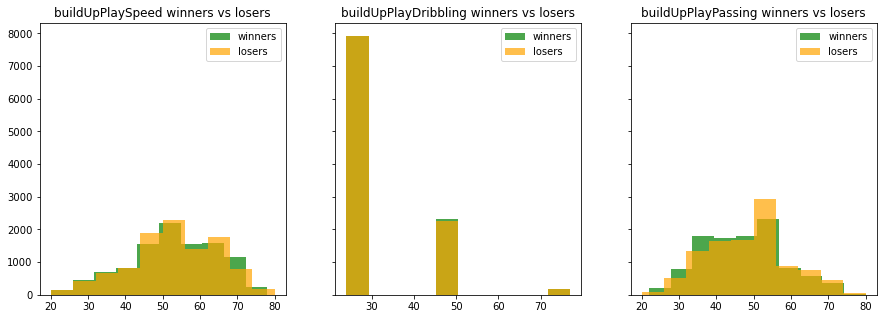

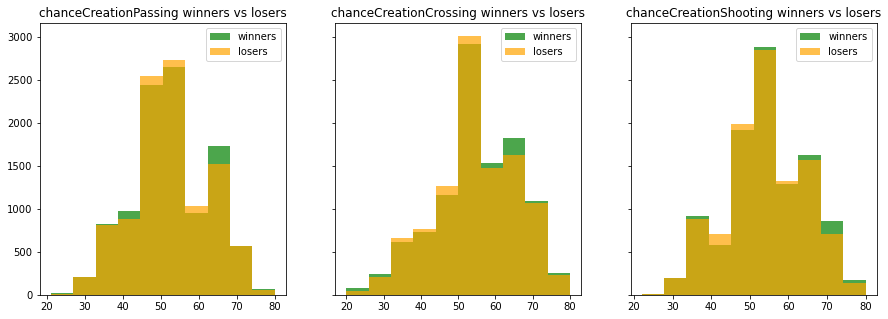

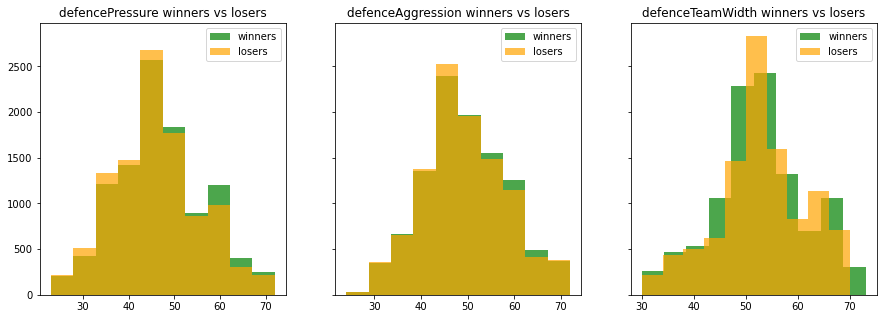

In [192]:
winner_color = 'green'
loser_color = 'orange'

def plotFields(fields):
  fig, axes = plt.subplots(1, len(fields), sharey='row')
  fig.set_figheight(5)
  fig.set_figwidth(5 * len(fields))

  for i in range(len(fields)):
    field = fields[i]
    axes[i].hist(df_winner_attrs[field], color=winner_color, alpha=0.7, label='winners')
    axes[i].hist(df_loser_attrs[field], color=loser_color, alpha=0.7, label='losers')
    axes[i].legend()
    axes[i].set_title(field + ' winners vs losers')
  
  plt.show()

plotFields(['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing'])
plotFields(['chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting'])
plotFields(['defencePressure', 'defenceAggression', 'defenceTeamWidth'])

### If we split the winners by league, do their team attributes vary?

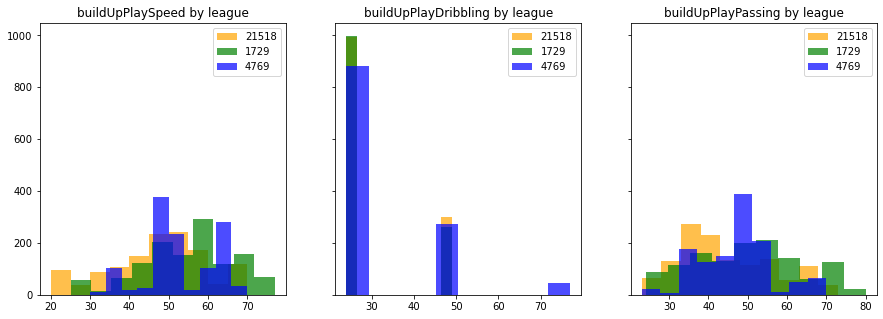

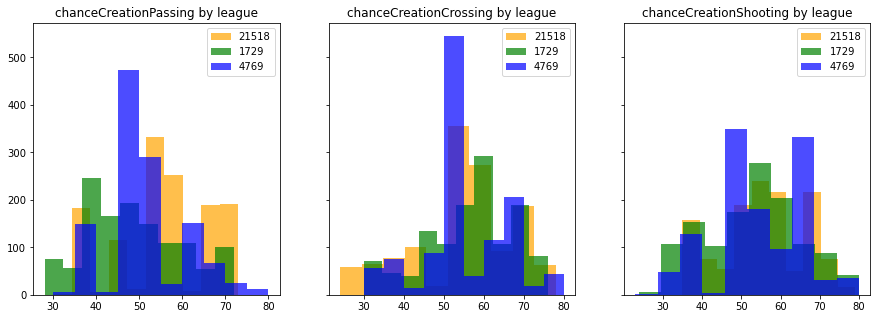

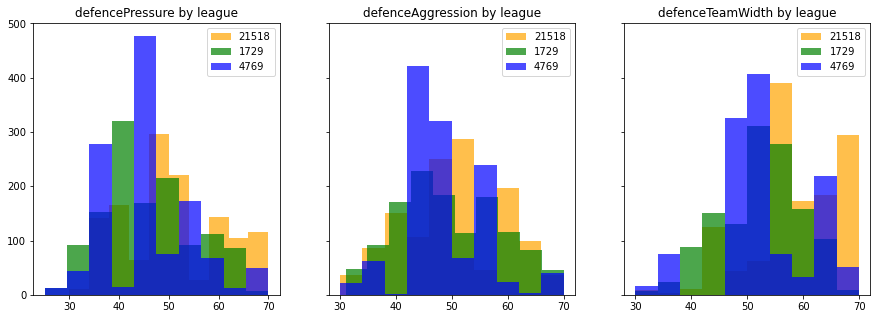

In [193]:
# We pick the 3 leagues with most samples with df_winner_attrs['league_id'].value_counts()
leagues = [21518, 1729, 4769]
df_winners_top_leagues = df_winner_attrs[df_winner_attrs['league_id'].isin(leagues)]

def plotFields(fields):
  color_0 = 'orange'
  color_1 = 'green'
  color_2 = 'blue'

  fig, axes = plt.subplots(1, len(fields), sharey='row')
  fig.set_figheight(5)
  fig.set_figwidth(5 * len(fields))

  for i in range(len(fields)):
    field = fields[i]
    axes[i].hist(df_winners_top_leagues[df_winners_top_leagues['league_id'] == leagues[0]][field], color=color_0, alpha=0.7, label=leagues[0])
    axes[i].hist(df_winners_top_leagues[df_winners_top_leagues['league_id'] == leagues[1]][field], color=color_1, alpha=0.7, label=leagues[1])
    axes[i].hist(df_winners_top_leagues[df_winners_top_leagues['league_id'] == leagues[2]][field], color=color_2, alpha=0.7, label=leagues[2])
    axes[i].legend()
    axes[i].set_title(field + ' by league')
  
  plt.show()

plotFields(['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing'])
plotFields(['chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting'])
plotFields(['defencePressure', 'defenceAggression', 'defenceTeamWidth'])


<a id='conclusions'></a>
## Conclusions

When it comes to answering the first question "What team attributes lead to the most victories?", we have to admit that **there are no clear differentiations between loser and winner teams**, we can see that in all of the presented plots, both graphs match. The only slight difference we can appreciate is with the `defenceTeamWidth`, where the distribution of the winner teams is less concentrated around the 50.

One of the main limitations on the approach followed here is that we are using team attributes that weren't measured the day on the match. The main problem with this, is that the team players vary from game to game, and with them the team attributes vary too. Instead, we're assuming that a single sample for the team attributes applies for the whole season.

In addition to the team players, results of a match may also vary due to external factors, such as weather, location (host or visitor), frequency between games (which may impact on players fatigue), etc. This reinforces that a single measure on the team attributes is not reliable for a whole season.

Jumping into the second question: "If we split the winners by league, do their team attributes vary?", we can see more interesting results. The plots here are not very different between leagues though, yet there are some details we can spot between them.

By looking at the [build-up](https://madaboutsports.in/what-is-build-up-in-football/#:~:text=To%20put%20simply%2C%20build%20up,via%20numerical%20or%20positional%20superiority.) play, we can see how the green league distribution is more skewed to the left on `buildUpPlaySpeed` than the blue and the yellow. This implies that teams in the green league which put the ball on the opponent's half faster, have more chance to win the game. On the other side, by taking a look at `buildUpPlayPassing` we observe that teams in the blue league who put the ball on the opponent's half through passes, have more chance of ending up winning the game.

Moving forward to the analysis of the [chance creation](https://www.reddit.com/r/soccer/comments/2xy59p/is_there_an_official_definition_for_chance/), we can see pretty similar visuals on the three plots. Fine graining a little bit, on the `chanceCreationPassing`, it seems like teams in the yellow league with a value between 50 and 70 have higher probability to win the game than teams in the other leagues under analysis. On the other hand, teams in the blue league with values between 45 and 55 have higher probability to win than other teams within the same league. It's also worth mentioning the spike in the blue league at `chanceCreationCrossing` centered in value 50.

In terms of defence, it's noticeable how teams in the yellow league with values higher than 55 have a lot more probability to be winners, where most of the blue league winners lay between 45 and 55. The rest of the charts offer similar distributions between the leagues.

Although we cannot see clear differences between winner attributes in the different leagues, we cannot say either that the same strategy applied to win a league will be effective on a different one. There are slight differences that should be taken into account when conforming a team, depending on the league we're aiming to lead.

When it comes to the limitations, the same we have for the same question apply to the second one.

## Submitting your Project 

In [194]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

1